## **Timeseries Forecasting Models**

Classical models generate forecasts by decomposing a series into deterministic and stochastic components. AR models compute outputs as weighted sums of previous observations, while MA models use past residual errors to adjust predictions—effectively modelling how unpredictable fluctuations propagate. 

ARMA combines both mechanisms. ARIMA introduces differencing to remove trends before applying ARMA logic, and SARIMA extends this with seasonal differencing to capture repeating periodic patterns. VAR generalises these ideas to multiple variables, where each output at time t is a linear combination of its own past values and the past values of all other series, allowing the model to express interdependent dynamics.

## Auto-Regressive Models

Auto-Regressive models treat future values as linear functions of past observations. The central idea is that the series carries information about its own future because the system generating it has memory or inertia. An AR model of order p (written AR(p)) predicts the next value as a weighted sum of the previous p values plus a noise term

Each φ coefficient captures how strongly a past timestamp influences the next one. A positive coefficient indicates momentum; a negative one indicates mean-reversion. The noise term εₜ represents random, unpredictable shocks that no model structure can capture

Two forecasting modes appear:

- Recursive forecasting: Predict one step, feed it back, continue.
- Direct forecasting: Train separate models for each horizon (t+1, t+2, t+3…).

Recursive forecasting is more autoregressive in nature, but error compounds.
Direct forecasting reduces error accumulation but requires more training and data.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [5]:
np.random.seed(0)
n = 300
phi = 0.6
noise = np.random.normal(0, 1, n)

x = np.zeros(n)
for t in range(1, n):
    x[t] = phi * x[t-1] + noise[t]

p = 5
X = []
y = []

for t in range(p, n):
    X.append(x[t-p:t])
    y.append(x[t])

X = np.array(X)
y = np.array(y)

In [6]:
def recursive_forecast(model, history, p, steps):
    """Generate multi-step forecasts by feeding each prediction back as input."""
    preds = []
    hist = list(history)

    for _ in range(steps):
        lag_window = np.array(hist[-p:]).reshape(1, -1)
        next_pred = model.predict(lag_window)[0]
        preds.append(next_pred)
        hist.append(next_pred)

    return np.array(preds)

In [20]:
model = LinearRegression()
model.fit(X, y)

phi_est = model.coef_
intercept_est = model.intercept_

future_steps = 100  # extend the forecast horizon
future_preds = recursive_forecast(model, history=x[-p:], p=p, steps=future_steps)


(array([ 0.0817401 , -0.02883748,  0.01982117,  0.06698689,  0.53871666]),
 np.float64(-0.0002852379519520977))

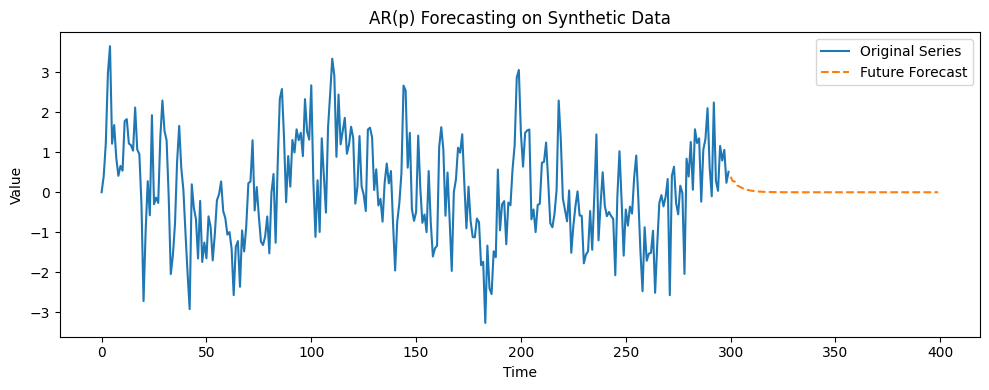

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(x, label="Original Series")
plt.plot(range(n, n + future_steps), future_preds, "--", label="Future Forecast")
plt.title("AR(p) Forecasting on Synthetic Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()

phi_est, intercept_est

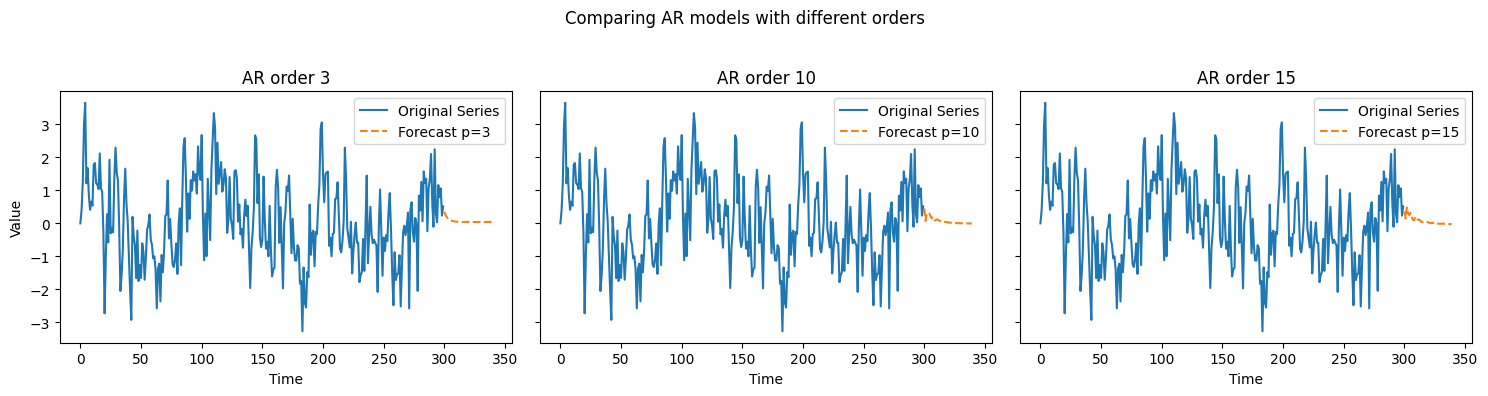

In [13]:
# Compare forecasts from three AR models with different orders
p_small, p_large, p_xlarge = 3, 10, 15


def fit_ar(order):
    X_local, y_local = [], []
    for t in range(order, n):
        X_local.append(x[t - order : t])
        y_local.append(x[t])
    return LinearRegression().fit(X_local, y_local)


model_small = fit_ar(p_small)
model_large = fit_ar(p_large)
model_xlarge = fit_ar(p_xlarge)

future_steps_compare = 40
pred_small = recursive_forecast(model_small, history=x[-p_small:], p=p_small, steps=future_steps_compare)
pred_large = recursive_forecast(model_large, history=x[-p_large:], p=p_large, steps=future_steps_compare)
pred_xlarge = recursive_forecast(model_xlarge, history=x[-p_xlarge:], p=p_xlarge, steps=future_steps_compare)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

axes[0].plot(x, label="Original Series")
axes[0].plot(range(n, n + future_steps_compare), pred_small, "--", label=f"Forecast p={p_small}")
axes[0].set_title(f"AR order {p_small}")
axes[0].legend()

axes[1].plot(x, label="Original Series")
axes[1].plot(range(n, n + future_steps_compare), pred_large, "--", label=f"Forecast p={p_large}")
axes[1].set_title(f"AR order {p_large}")
axes[1].legend()

axes[2].plot(x, label="Original Series")
axes[2].plot(range(n, n + future_steps_compare), pred_xlarge, "--", label=f"Forecast p={p_xlarge}")
axes[2].set_title(f"AR order {p_xlarge}")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Time")
axes[0].set_ylabel("Value")
plt.suptitle("Comparing AR models with different orders")
plt.tight_layout(rect=(0, 0, 1, 0.95))


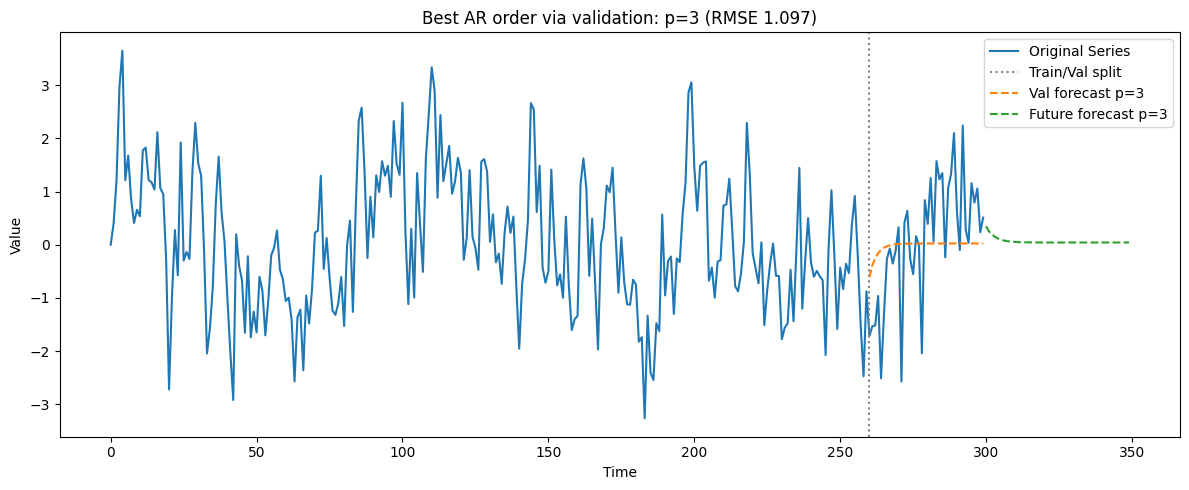

In [24]:
# Pick the AR order via validation and forecast with the best model
val_size = 40
candidate_orders = [3, 5, 10, 20]


def fit_ar_until(series, order, end_idx):
    X_local, y_local = [], []
    for t in range(order, end_idx):
        X_local.append(series[t - order : t])
        y_local.append(series[t])
    return LinearRegression().fit(X_local, y_local)


def validation_rmse(series, order, val_size):
    split_idx = len(series) - val_size
    model = fit_ar_until(series, order, split_idx)
    preds_val = recursive_forecast(model, history=series[split_idx - order : split_idx], p=order, steps=val_size)
    return np.sqrt(mean_squared_error(series[split_idx:], preds_val))


order_scores = {order: validation_rmse(x, order, val_size) for order in candidate_orders}
best_order = min(order_scores, key=order_scores.get)

best_model = fit_ar_until(x, best_order, len(x))
future_steps_best = 50
best_preds = recursive_forecast(best_model, history=x[-best_order:], p=best_order, steps=future_steps_best)

plt.figure(figsize=(12, 5))
plt.plot(x, label="Original Series")
plt.axvline(len(x) - val_size, color="gray", linestyle=":", label="Train/Val split")

# Show validation fit continuation
val_start = len(x) - val_size
plt.plot(range(val_start, len(x)), recursive_forecast(fit_ar_until(x, best_order, val_start), history=x[val_start - best_order : val_start], p=best_order, steps=val_size),
         "--", label=f"Val forecast p={best_order}")

plt.plot(range(len(x), len(x) + future_steps_best), best_preds, "--", label=f"Future forecast p={best_order}")
plt.title(f"Best AR order via validation: p={best_order} (RMSE {order_scores[best_order]:.3f})")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()



## Moving-Averages Models

Moving Average (MA) models describe future values not through past observations themselves, but through past forecast errors. Instead of assuming the system has direct memory of its past values, MA models assume the system’s future behavior depends on how it previously deviated from expectations. An MA model of order q (written MA(q)) predicts the next value as a weighted sum of the last q noise terms

Each θ coefficient captures how strongly a past shock influences the next value. A positive θ means the system tends to propagate shocks forward, while a negative θ means shocks tend to be corrected quickly. Because MA models explicitly incorporate the error structure, they are excellent at modelling sudden spikes, temporary disturbances, or noise patterns that decay over time

Recursive forecasting in MA models requires careful handling because future residuals are unknown—they must be approximated, which can flatten long-term predictions. Direct forecasting avoids this drift but requires clean estimation of the noise structure and typically flattens toward the unconditional mean when projecting far ahead

In [25]:
np.random.seed(7)
n_ma = 320
mu = 0.0
theta1, theta2 = 0.6, -0.4
noise_ma = np.random.normal(0, 1, n_ma)

ma_series = np.zeros(n_ma)
for t in range(2, n_ma):
    ma_series[t] = (
        mu
        + noise_ma[t]
        + theta1 * noise_ma[t - 1]
        + theta2 * noise_ma[t - 2]
    )

In [26]:
def sma_forecast(history, window, steps, recursive=True):
    """Simple moving-average forecast using the last `window` observations."""
    hist = list(history)
    preds = []
    for _ in range(steps):
        preds.append(np.mean(hist[-window:]))
        hist.append(preds[-1] if recursive else hist[-1])
    return np.array(preds)


def walkforward_rmse(series, window, val_size):
    train = list(series[:-val_size])
    val = series[-val_size:]
    preds = []
    hist = train.copy()
    for actual in val:
        preds.append(np.mean(hist[-window:]))
        hist.append(actual)  # one-step update with ground truth
    return np.sqrt(mean_squared_error(val, preds))

In [27]:
candidate_windows = [3, 5, 8, 15]
val_size_ma = 60
window_scores = {w: walkforward_rmse(ma_series, w, val_size_ma) for w in candidate_windows}
best_window = min(window_scores, key=window_scores.get)

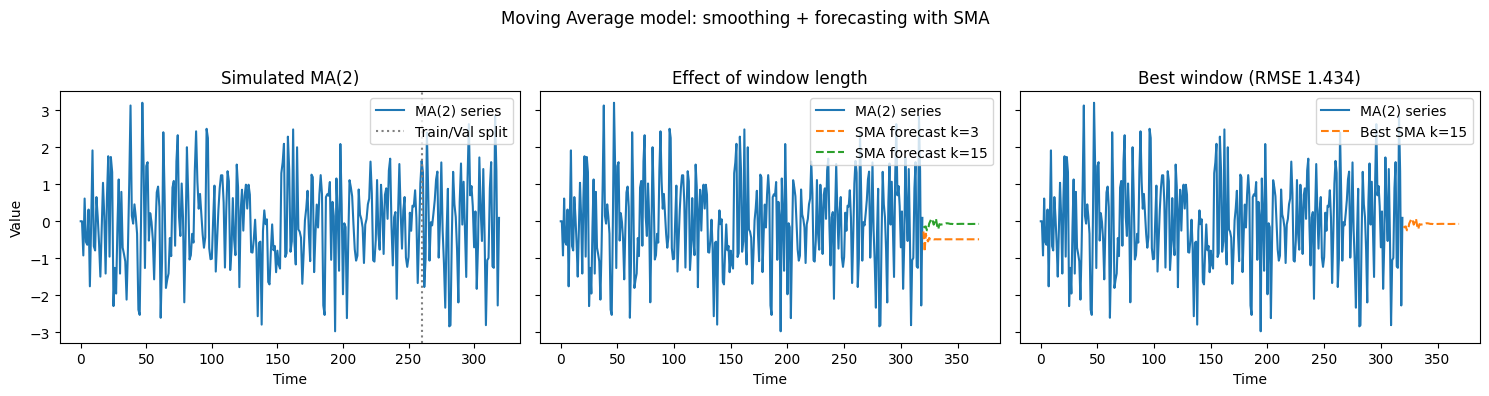

In [28]:
future_steps_ma = 50
best_preds_ma = sma_forecast(ma_series[-best_window:], window=best_window, steps=future_steps_ma)

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Show full MA series
axes[0].plot(ma_series, label="MA(2) series")
axes[0].axvline(len(ma_series) - val_size_ma, color="gray", linestyle=":", label="Train/Val split")
axes[0].set_title("Simulated MA(2)")
axes[0].legend()

# Compare two window sizes
w_short, w_long = 3, 15
pred_short = sma_forecast(ma_series[-w_short:], window=w_short, steps=future_steps_ma)
pred_long = sma_forecast(ma_series[-w_long:], window=w_long, steps=future_steps_ma)
axes[1].plot(ma_series, label="MA(2) series")
axes[1].plot(range(n_ma, n_ma + future_steps_ma), pred_short, "--", label=f"SMA forecast k={w_short}")
axes[1].plot(range(n_ma, n_ma + future_steps_ma), pred_long, "--", label=f"SMA forecast k={w_long}")
axes[1].set_title("Effect of window length")
axes[1].legend()

# Best window via validation
axes[2].plot(ma_series, label="MA(2) series")
axes[2].plot(range(n_ma, n_ma + future_steps_ma), best_preds_ma, "--", label=f"Best SMA k={best_window}")
axes[2].set_title(f"Best window (RMSE {window_scores[best_window]:.3f})")
axes[2].legend()

for ax in axes:
    ax.set_xlabel("Time")
axes[0].set_ylabel("Value")
plt.suptitle("Moving Average model: smoothing + forecasting with SMA")
plt.tight_layout(rect=(0, 0, 1, 0.95))

